# **1. BUG IN MCS**

- 1727 

In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
#root_dir = Path(__file__).parents[1]
root_dir = Path().resolve().parent

# Append the parent directory to sys.path
sys.path.append(str(root_dir))

from SynRBL.rsmi_utils import load_database, save_database
from SynRBL.SynMCS.extract_common_mcs import ExtractMCS


def main(percentage=100):
    original_data = load_database(f'{root_dir}/Data/Unsolved_reactions.json.gz')
    condition_1 = load_database(f'{root_dir}/Data/MCS/Condition_1.json.gz')
    condition_2 = load_database(f'{root_dir}/Data/MCS/Condition_2.json.gz')
    condition_3 = load_database(f'{root_dir}/Data/MCS/Condition_3.json.gz')
    condition_4 = load_database(f'{root_dir}/Data/MCS/Condition_4.json.gz')

    analysis = ExtractMCS()
    mcs_dict, threshold_index = analysis.extract_common_mcs(percentage, condition_1, condition_2, condition_3, condition_4)
    data_solve = [d for d, b in zip(original_data, threshold_index) if b]

    save_database(mcs_dict, f'{root_dir}/Data/MCS/Intersection_MCS.json.gz')
    save_database(data_solve, f'{root_dir}/Data/MCS/MCS_Solved_reactions.json.gz')

    return

if __name__ == "__main__":
    main(percentage=100)


In [2]:
from collections import Counter
import pandas as pd

class ExtractMCS:
    """
    A class to extract and analyze the most common Maximum Common Substructure (MCS) from a list of MCS results.
    Provides functionality to determine the most common elements, the top n common elements, and to calculate
    the corrected individual overlap percentage for multiple conditions. Additionally, extracts the MCS results
    that meet a specified threshold for commonality.
    """

    def get_popular_elements_from_list(self, elements_list):
        """
        Get the most popular elements in a flat list.

        :param elements_list: A list containing elements.
        :return: A list of elements that appear with the highest frequency in the provided list.
        """
        element_count = Counter(elements_list)
        max_frequency = max(element_count.values(), default=0)
        return [element for element, count in element_count.items() if count == max_frequency]

    def get_top_n_common_elements(self, elements_list, top_n=2):
        """
        Get the top n most common elements from a list of sets.

        :param elements_list: A list of sets, each containing elements.
        :param top_n: The number of top elements to retrieve.
        :return: A list of the top n most common elements across all sets.
        """
        flattened_elements = [element for element_set in elements_list for element in element_set]
        return [element for element, _ in Counter(flattened_elements).most_common(top_n)]

    def calculate_corrected_individual_overlap_percentage(self, *conditions):
        """
        Calculate the corrected individual overlap percentage across multiple conditions.

        :param conditions: A variable number of conditions, each a list of dictionaries containing 'mcs_results'.
        :return: A list of overlap percentages for each index across the conditions.
        :raises ValueError: If all conditions do not have the same number of cases.
        """
        if not all(len(condition) == len(conditions[0]) for condition in conditions):
            raise ValueError("All conditions must have the same number of cases")

        num_conditions = len(conditions)
        list_overlap_percentages = []
        reference_results_list = []

        for idx in range(len(conditions[0])):
            list_length = [len(condition[idx]['mcs_results']) for condition in conditions]
            len_popular = self.get_popular_elements_from_list(list_length)[0]
            current_results = [set(condition[idx]['mcs_results']) for condition in conditions]
            reference_results = self.get_top_n_common_elements(current_results, top_n=len_popular)
            reference_results_list.append(reference_results)
            overlap_count = sum(sorted(reference_results) == sorted(set(condition[idx]['mcs_results'])) for condition in conditions)
            overlap_percentage = (overlap_count / num_conditions) * 100
            list_overlap_percentages.append(overlap_percentage)

        return list_overlap_percentages, reference_results_list

    def extract_common_mcs_index(self, lower_threshold,upper_threshold, *conditions):
        """
        Extract MCS results that meet a specified threshold for commonality.

        :param threshold: The percentage threshold for commonality.
        :param conditions: A variable number of conditions, each a list of dictionaries containing 'mcs_results'.
        :return: A list of dictionaries representing the MCS results that meet the specified threshold.
        """
        overlap_percentages, reference_results_list = self.calculate_corrected_individual_overlap_percentage(*conditions)
        threshold_index = [lower_threshold <= i <= upper_threshold for i in overlap_percentages]
        #mcs_common = [d for d, b in zip(conditions[0], threshold_index) if b]
        return threshold_index, reference_results_list
    

    def extract_matching_conditions(self, lower_threshold,upper_threshold, *conditions):
        """
        Extract and return the first matching condition for each index that meets the threshold.

        :param threshold_index: A list of boolean values indicating whether each condition meets the threshold.
        :param conditions: A list of conditions, each a list of dictionaries containing 'mcs_results'.
        :param reference_results_list: A list of reference results to match against the conditions.
        :return: A list of dictionaries representing the matching condition for each index that meets the threshold.
        """
        threshold_index, reference_results_list = self.extract_common_mcs_index(lower_threshold,upper_threshold, *conditions)
        results = []
        for key, value in enumerate(threshold_index):
            if value:
                try:
                    for condition in conditions:
                        if sorted(reference_results_list[key]) == sorted(set(condition[key]['mcs_results'])):
                            results.append(condition[key])
                            break
                except Exception as e:
                    print(f"Error processing condition at index {key}: {e}")
                    continue
        return results, threshold_index




In [160]:
from rdkit import Chem

def get_num_atoms(smiles):
    """
    Returns the number of atoms in a molecule represented by a SMILES string.

    :param smiles: A string representing a molecule in SMILES format.
    :return: An integer count of the number of atoms in the molecule.
    """
    molecule = Chem.MolFromSmiles(smiles, sanitize = False)
    if molecule is not None:
        return molecule.GetNumAtoms()
    else:
        raise ValueError("Invalid SMILES string")



Number of atoms in CCO: 3


In [174]:
def calcutate_total_number_atoms_mcs(condition):
    total_number_atoms = []
    for d in condition:
        number_atoms = 0
        for mcs in d['mcs_results']:
            number_atoms += get_num_atoms(mcs)

        total_number_atoms.append(number_atoms)

    return total_number_atoms

TypeError: list indices must be integers or slices, not str

In [182]:
from rdkit import Chem

def calcutate_total_number_atoms_mcs(condition):
    total_number_atoms = []
    for d in condition:
        number_atoms = 0
        for mcs in d['mcs_results']:
            number_atoms += get_num_atoms(mcs)

        total_number_atoms.append(number_atoms)

    return total_number_atoms

def compare_conditions_and_get_largest(*conditions):
    results = []

    # Find the shortest list length among conditions to ensure index alignment
    min_length = min(len(calcutate_total_number_atoms_mcs(cond)) for cond in conditions)

    for idx in range(min_length):
        max_atoms = 0
        max_condition_index = -1
        max_mcs = ""

        for condition_idx, condition in enumerate(conditions):
            mcs_list = calcutate_total_number_atoms_mcs(condition)
            if idx < len(mcs_list) and mcs_list[idx] > max_atoms:
                max_atoms = mcs_list[idx]
                max_condition_index = condition_idx
                max_mcs = condition['mcs_results'][idx]

        if max_condition_index != -1:
            results.append({"name": f"Condition {max_condition_index + 1}", "biggest_mcs": max_mcs})

    return results

# Example usage
conditions = [condition_1, condition_2, condition_3, condition_4]  # Replace with your actual condition data
largest_mcs_results = compare_conditions_and_get_largest(*conditions)
print(largest_mcs_results)


TypeError: list indices must be integers or slices, not str

In [185]:
from rdkit import Chem

# Function to get the number of atoms from a SMILES string
def get_num_atoms(smiles):
    try:
        molecule = Chem.MolFromSmiles(smiles, satinize = False)
        if molecule is not None:
            return molecule.GetNumAtoms()
        else:
            return 0
    except:
        return 0

# Function to calculate the total number of atoms in MCS results for each dictionary in the condition
def calcutate_total_number_atoms_mcs(condition):
    total_number_atoms = []
    for d in condition:
        number_atoms = 0
        for mcs in d['mcs_results']:
            number_atoms += get_num_atoms(mcs)
        total_number_atoms.append(number_atoms)
    return total_number_atoms

# Function to compare conditions and get the largest MCS based on the total number of atoms
def compare_conditions_and_get_largest(*conditions):
    results = []

    # Find the shortest list length among conditions to ensure index alignment
    min_length = min(len(cond) for cond in conditions)

    for idx in range(min_length):
        max_atoms = 0
        max_condition_index = -1
        max_mcs = ""

        for condition_idx, condition in enumerate(conditions):
            total_number_atoms = calcutate_total_number_atoms_mcs(condition)
            if idx < len(total_number_atoms) and total_number_atoms[idx] > max_atoms:
                max_atoms = total_number_atoms[idx]
                max_condition_index = condition_idx
                max_mcs = condition[idx]['mcs_results']
        print(max_mcs)
        if max_condition_index != -1:
            results.append({"name": f"Condition {max_condition_index + 1}", "biggest_mcs": max_mcs})

    return results

# Example usage

conditions = [condition_1, condition_2, condition_3, condition_4]  # Replace with your actual condition data
largest_mcs_results = compare_conditions_and_get_largest(*conditions)
print(largest_mcs_results)

In [6]:
from rdkit import Chem
from joblib import Parallel, delayed

# Function to get the number of atoms from a SMILES string
def get_num_atoms(smiles):
    try:
        molecule = Chem.MolFromSmiles(smiles, sanitize=False)
        if molecule is not None:
            return molecule.GetNumAtoms()
        else:
            return 0
    except:
        return 0

# Function to calculate the total number of atoms in MCS results for each dictionary in the condition
def calculate_total_number_atoms_mcs(condition):
    total_number_atoms = []
    for d in condition:
        number_atoms = 0
        for mcs in d['mcs_results']:
            number_atoms += get_num_atoms(mcs)
        total_number_atoms.append(number_atoms)
    return total_number_atoms

# Function to process each index and find the largest MCS
def process_index(idx, conditions):
    max_atoms = 0
    max_condition_index = -1
    max_mcs = ""

    for condition_idx, condition in enumerate(conditions):
        total_number_atoms = calculate_total_number_atoms_mcs(condition)
        if idx < len(total_number_atoms) and total_number_atoms[idx] > max_atoms:
            max_atoms = total_number_atoms[idx]
            max_condition_index = condition_idx
            max_mcs = condition[idx]['mcs_results']

    if max_condition_index != -1:
        return {"name": f"Condition {max_condition_index + 1}", "biggest_mcs": max_mcs}
    else:
        return None

# Modified function to use joblib for parallel processing
def compare_conditions_and_get_largest_parallel(*conditions, n_jobs=4):
    min_length = min(len(cond) for cond in conditions)
    results = Parallel(n_jobs)(delayed(process_index)(idx, conditions) for idx in range(min_length))
    return [result for result in results if result is not None]



conditions = [condition_1, condition_2, condition_3, condition_4]  
largest_mcs_results = compare_conditions_and_get_largest_parallel(*conditions, n_jobs=4)
print(largest_mcs_results)


In [ ]:
largest_mcs_results

In [178]:
len(conditions)

4

In [179]:
condition_1

[{'mcs_results': ['COC(=O)C(CCCCN)NC(=O)NC1:C:C(OC):C:C(C(C)(C)C):C:1O'],
  'sorted_reactants': ['COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'],
  'issue': []},
 {'mcs_results': ['C1:C:C:C(OCC2:C:C:C3:C:C:C:C:C:3:N:2):C:C:1',
   'N#CC1:C:C:C(OC2CCCCO2):C:C:1'],
  'sorted_reactants': ['CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C',
   'N#Cc1ccc(OC2CCCCO2)c(Br)c1'],
  'issue': []},
 {'mcs_results': ['O=C(O)CONC(=O)NCC1:C:C:C:C2:C:C:C:C:C:1:2'],
  'sorted_reactants': ['CC(C)(C)OC(=O)CONC(=O)NCc1cccc2ccccc12'],
  'issue': []},
 {'mcs_results': ['CCOC(=O)C1:N:N:N:C:1C(=O)C1:C:C:C(OC):C(OC):C:1'],
  'sorted_reactants': ['CCOC(=O)c1nnn(Cc2ccc(OC)cc2)c1C(=O)c1ccc(OC)c(OC)c1'],
  'issue': []},
 {'mcs_results': ['CC(C)N1:N:C(C2:C:C:C(O):C:C:2):C2:C:C:C:C(Cl):C:2:1'],
  'sorted_reactants': ['COc1ccc(-c2nn(C(C)C)c3c(Cl)cccc23)cc1'],
  'issue': []},
 {'mcs_results': ['CCN(C1:N:C(F):C:C:C:1NC(C)C)C1CCNCC1'],
  'sorted_reactants': ['CCN(c1nc(F)ccc1NC(C)C)C1CCN(Cc2ccccc2)CC1'],
  '

In [170]:
num_atoms_1 = calcutate_total_number_atoms_mcs(condition_1)
num_atoms_2 = calcutate_total_number_atoms_mcs(condition_2)
num_atoms_3 = calcutate_total_number_atoms_mcs(condition_3)
num_atoms_4 = calcutate_total_number_atoms_mcs(condition_4)


In [171]:
num_atoms_4

[27,
 33,
 20,
 22,
 20,
 20,
 22,
 27,
 15,
 31,
 39,
 16,
 31,
 18,
 28,
 26,
 24,
 20,
 17,
 12,
 37,
 39,
 20,
 17,
 28,
 44,
 12,
 19,
 30,
 32,
 27,
 28,
 34,
 28,
 16,
 15,
 14,
 24,
 19,
 12,
 21,
 25,
 11,
 31,
 30,
 12,
 22,
 22,
 24,
 42,
 39,
 19,
 28,
 12,
 8,
 14,
 33,
 32,
 19,
 28,
 26,
 16,
 18,
 23,
 12,
 34,
 22,
 17,
 29,
 14,
 11,
 35,
 15,
 17,
 14,
 34,
 18,
 23,
 35,
 35,
 32,
 24,
 16,
 39,
 17,
 34,
 26,
 17,
 16,
 10,
 27,
 32,
 29,
 13,
 15,
 40,
 23,
 28,
 33,
 33,
 21,
 17,
 21,
 29,
 25,
 21,
 19,
 27,
 20,
 17,
 26,
 28,
 20,
 17,
 30,
 30,
 45,
 15,
 23,
 15,
 34,
 44,
 20,
 12,
 24,
 28,
 26,
 29,
 40,
 35,
 29,
 24,
 18,
 15,
 33,
 27,
 19,
 42,
 16,
 27,
 14,
 17,
 19,
 24,
 38,
 17,
 36,
 36,
 20,
 18,
 18,
 17,
 21,
 35,
 20,
 22,
 13,
 31,
 22,
 20,
 17,
 61,
 20,
 29,
 21,
 30,
 15,
 26,
 27,
 14,
 20,
 21,
 12,
 25,
 28,
 15,
 22,
 15,
 34,
 27,
 43,
 33,
 35,
 32,
 20,
 30,
 18,
 30,
 30,
 34,
 25,
 45,
 20,
 18,
 16,
 32,
 49,
 35,
 12,
 12,
 

In [ ]:
for key

In [3]:
original_data = load_database(f'{root_dir}/Data/Unsolved_reactions.json.gz')
condition_1 = load_database(f'{root_dir}/Data/MCS/Condition_1.json.gz')
condition_2 = load_database(f'{root_dir}/Data/MCS/Condition_2.json.gz')
condition_3 = load_database(f'{root_dir}/Data/MCS/Condition_3.json.gz')
condition_4 = load_database(f'{root_dir}/Data/MCS/Condition_4.json.gz')

analysis = ExtractMCS()
mcs_dict , threshold_index= analysis.extract_matching_conditions(25, 25, condition_1, condition_2, condition_3, condition_4)
data_solve = [d for d, b in zip(original_data, threshold_index) if b]

In [4]:
condition_1[0]['mcs_results']

['COC(=O)C(CCCCN)NC(=O)NC1:C:C(OC):C:C(C(C)(C)C):C:1O']

In [157]:
for i

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [148]:
from SynRBL.SynMCS.mcs_utils import smiles_to_mol_parallel
msc_df = pd.DataFrame(mcs_dict)
mcs_results = msc_df['mcs_results'].to_list()
sorted_reactants = msc_df['sorted_reactants'].to_list()

mcs_mol_list = smiles_to_mol_parallel(mcs_results)
sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)


[18:03:56] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:03:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9 23 24 25
[18:03:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 20 21 22
[18:03:56] Can't kekulize mol.  Unkekulized atoms: 7 8 9 12 13
[18:03:56] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:03:56] Can't kekulize mol.  Unkekulized atoms: 14 15 18 19 25 28 29
[18:03:56] Explicit valence for atom # 13 N, 4, is greater than permitted
[18:03:56] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[18:03:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[18:03:56] Explicit valence for atom # 6 N, 4, is greater than permitted
[18:03:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 11 12
[18:03:56] Explicit valence for atom # 15 N, 4, is greater than permitted
[18:03:56] Can't kekulize mol.  Unkekulized atoms: 5 6 9
[18:03:56] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[18:03:56] Explicit valence for 

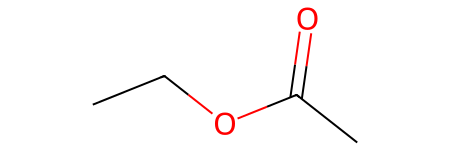

In [149]:
mcs_mol_list[0][1]

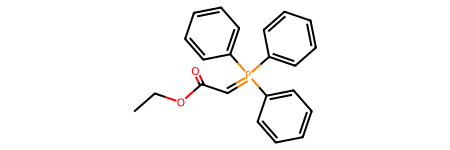

In [150]:
sorted_reactants_mol_list[0][1]    

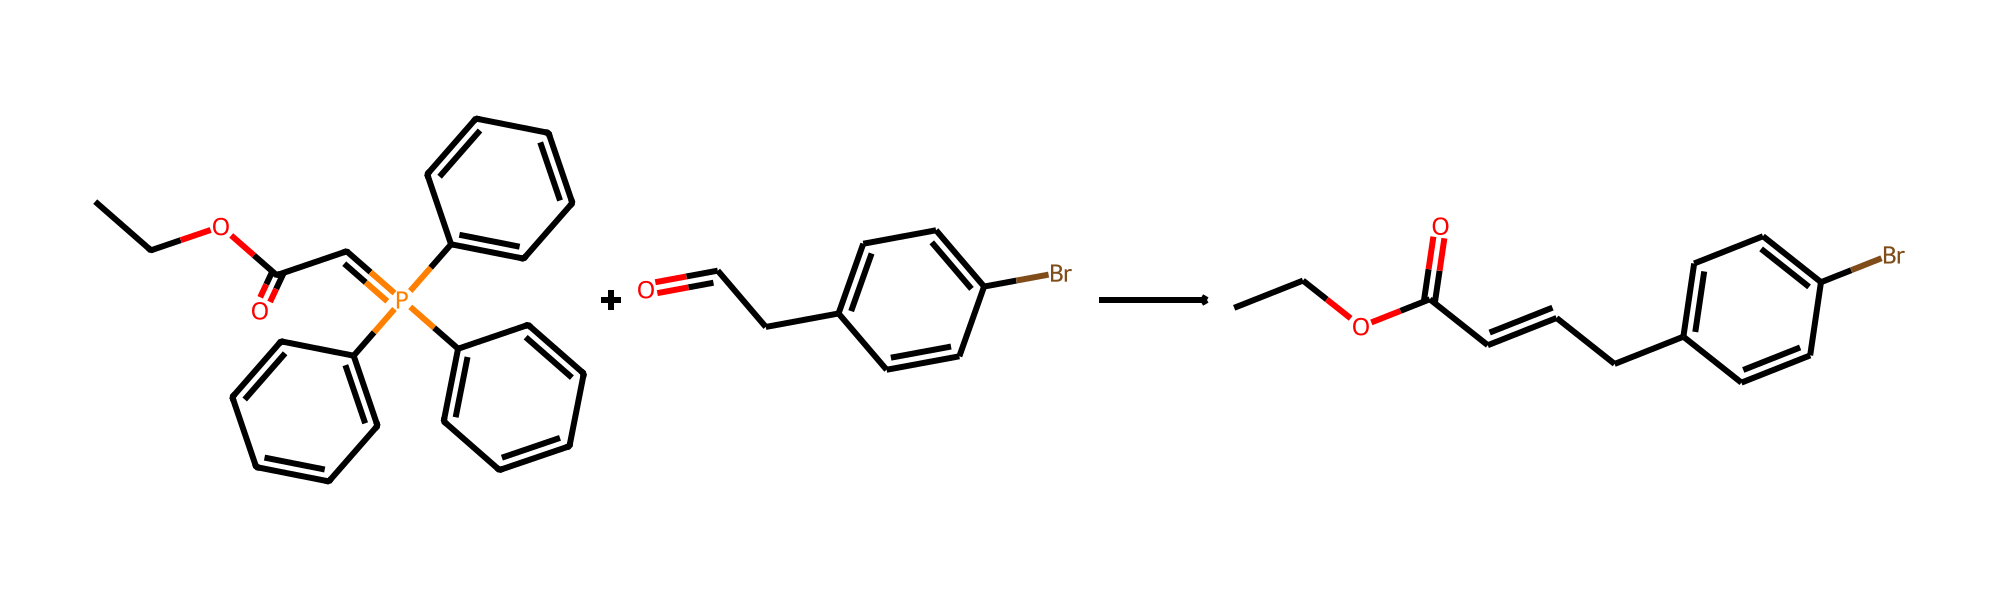

In [151]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.visualize_reaction(data_solve[0]['reactions'])


In [152]:
from SynRBL.SynMCS.find_missing_graphs import FindMissingGraphs
find_graph = FindMissingGraphs()
missing_results = find_graph.find_missing_parts_pairs( sorted_reactants_mol_list[0], mcs_mol_list[0],use_findMCS=True)

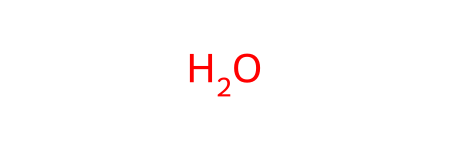

In [154]:
missing_results[0][0]

IndexError: list index out of range

In [65]:
conditions = [condition_1, condition_2, condition_3, condition_4]

In [67]:
condition_1[0]['mcs_results']

['COC(=O)C(CCCCN)NC(=O)NC1:C:C(OC):C:C(C(C)(C)C):C:1O']

In [73]:
results = []
for key, value in enumerate(threshold_index):
    if value:
        try:
            for condition in conditions:
                if sorted(reference_results_list[key]) == sorted(set(condition[key]['mcs_results'])):
                    results.append(condition[key])
                    break
        except:
            pass


In [74]:
len(results)

17459

In [62]:
reference_results_list

[['COC(=O)C(CCCCN)NC(=O)NC1:C:C(OC):C:C(C(C)(C)C):C:1O'],
 ['C1:C:C:C(OCC2:C:C:C3:C:C:C:C:C:3:N:2):C:C:1',
  'N#CC1:C:C:C(OC2CCCCO2):C:C:1'],
 ['O=C(O)CONC(=O)NCC1:C:C:C:C2:C:C:C:C:C:1:2'],
 ['CCOC(=O)C1:N:N:N:C:1C(=O)C1:C:C:C(OC):C(OC):C:1'],
 ['CC(C)N1:N:C(C2:C:C:C(O):C:C:2):C2:C:C:C:C(Cl):C:2:1'],
 ['CCN(C1:N:C(F):C:C:C:1NC(C)C)C1CCNCC1'],
 ['C#CC1:C:O:C2:C:C:C(C(=O)NC3CN4CCC3CC4):C:C:1:2'],
 ['CC(=O)C1:C:C:C:C:C:1OC1:C:N:N(C(CC2CCCC2)C(=O)O):C(=O):C:1'],
 ['CCC1:C:C:C(Br):C:C:1', 'CCOC(C)=O'],
 ['CNC1CCC(C2:C:C:C(Cl):C(Cl):C:2)C2:C:C:C(C(=O)OC):C:C:21', 'CC(C)(C)O'],
 ['CCN',
  'COC1:C:C:C(N2:C(C=O):C(OCC3:C:C:C:C:C:3):C(OCC3:C:C:C:C:C:3):C:2C(=O)N(C)C):C:C:1'],
 ['CC1:C:C:C(C(=O)O):C:C:1F', 'Br'],
 ['CC1:C:C:C(C(=O)N2CCC(C3:C:C:C(C#N):C:C:3)CC2):C:C:1NS(=O)(=O)CC(=O)O'],
 ['C1=CCC2(CC1)OCCO2', 'COC1:C:C:C:C:C:1'],
 ['NCC1CCCCN1', 'O=CC1:C:C(OCC(F)(F)F):C:C:C:1OCC(F)(F)F'],
 ['O=C(O)CCC1:C(C=C2C(=O)NC3:C:C:C:C:C:32):N:C2:C:1C(=O)CCC2'],
 ['N', 'O=CC1:N:C:C(C2:C:C:C:C(C3:C:C:C:C:C:3

In [61]:
len(reference_results_list)

18682

In [23]:
len(original_data) - len(mcs_dict)

1727

In [37]:
len(original_data)

18682

In [27]:
len(mcs_dict)

16955

# **2. BUG IN FINDGRAPH**

- 423 can not be solved

In [33]:
from SynRBL.SynMCS.find_missing_graphs import FindMissingGraphs
from SynRBL.SynMCS.mcs_utils import smiles_to_mol_parallel



In [49]:
msc_df = pd.DataFrame(mcs_dict)

mcs_results = msc_df['mcs_results'].to_list()
sorted_reactants = msc_df['sorted_reactants'].to_list()

mcs_mol_list = smiles_to_mol_parallel(mcs_results)
sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

find_graph = FindMissingGraphs()
missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=4, use_findMCS=True)


[16:27:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:27:04] Can't kekulize mol.  Unkekulized atoms: 5 6 18 19 20
[16:27:04] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 22
[16:27:04] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[16:27:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 25 26 27
[16:27:04] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:27:04] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:27:04] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 21 22 23 24
[16:27:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 16 17 18
[16:27:04] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 23 24 25 26 27 28 32 33 34
[16:27:04] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 14 15
[16:27:04] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:27:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 12
[16:27:04] Explicit valence for atom # 22 N, 4, is greater than permitted
[16

In [55]:
missing_final = pd.DataFrame(missing_results)
missing_final = missing_final.applymap(lambda x: np.nan if x == [] else x)
final_df = missing_final.dropna(subset=['smiles', 'boundary_atoms_products'])

/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_68879/2797405848.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  missing_final = missing_final.applymap(lambda x: np.nan if x == [] else x)


In [56]:
len(mcs_dict)-final_df.shape[0]

423

In [32]:
pd.DataFrame(final_graph).dropna(subset=['smiles']).shape

(16955, 4)